# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-reinvent-track.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Run these command if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>

In [ ]:
# #
# # Run these commands only for the first time
# #
# # Clean the build directory if present
# !python3 sim_app_bundler.py --clean

# # Download Robomaker simApp from the deepracer public s3 bucket
# simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
# !aws s3 cp {simulation_application_bundle_location} ./

# # Untar the simapp bundle
# !python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# # Now modify the simapp(Robomaker) from build directory and run this command.

# # Most of the simapp files can be found here (Robomaker changes). You can modify them in these locations
# # bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/
# # bundle/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/
# # bundle/opt/install/deepracer_simulation_environment/lib/deepracer_simulation_environment/

# # # Copying the notebook src/markov changes to the simapp (For sagemaker container)
# !rsync -av ./src/markov/ ./build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov

# print("############################################")
# print("This command execution takes around >2 min...")
# !python3 sim_app_bundler.py --tar

## Get latest markov package from the bundle to run on SageMaker instance

In [ ]:
# #
# # Run these commands only for the first time
# #
# # Clean the build directory if present
# !python3 sim_app_bundler.py --clean

# # Download Robomaker simApp from the deepracer public s3 bucket
# simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
# !aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

# # Untar the simapp bundle
# !python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# !rm -rf ./src/markov
# !cp -r build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov ./src/

# # Remove build & deepracer-simapp.tar.gz
# !rm -rf build
# !rm -rf deepracer-simapp.tar.gz

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [ ]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml
sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Initializing basic parameters

In [ ]:
# code to create a new bucket or use an existing bucket with allowed permissions
useExistingBucket = True
#if true , use exiting models else create a new model, make sure name is unique and add it to our 
#existing bucket only create a new folder
FreireBucket = "freirebros-deepracer" #bucketname , this is global bucket (S3 Bucket)

#the pretrained folder is incase yo have an old model already trained
#if you have non then just call it ""
#DO NOT PUT A  SLASH AT THE END IT MESSES EVERYTHING UP
#pretrainedModelPrefix = "AndreiModels/Model-Andrei-Trial-4-usingT3-SM" #this is the prefix name (a folder within sagemaker S3)
#new model directory
NewModelPrefix = "AndreiModels/Model-Andrei-Trial-1-Continuous"

# Select the instance type
instance_type = "ml.c4.2xlarge"
#instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"


if not FreireBucket: 
    raise SystemExit("Please Enter a Bucket Name")

# Starting SageMaker session
sage_session = sagemaker.session.Session(default_bucket = FreireBucket)

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [ ]:
#Fetch S3 Bucket Resource
if not NewModelPrefix:
    raise systemExit("pleaser Enter a Prefix Name (Folder where the model is stored)")
# S3 bucket
if not useExistingBucket:
    s3_bucket = sage_session.default_bucket()
else:
    s3_bucket = FreireBucket
# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = NewModelPrefix

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [ ]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook
In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.

In [ ]:
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))

### Permission setup for Sagemaker to S3 bucket

The sagemaker writes the Redis IP address, models to the S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [ ]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))

### Permission setup for Sagemaker to create KinesisVideoStreams

The sagemaker notebook has to create a kinesis video streamer. You can observer the car making epsiodes in the kinesis video streamer.

In [ ]:
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

### Build and push docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container. We will be using this docker container.

In [ ]:
%%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)

### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [ ]:
# !docker rm -f $(docker ps -a -q);
# !docker rmi -f $(docker images -q);

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will check if the deepracer-vpc stack is created and use it if present (This is present if the AWS Deepracer console is used atleast once to create a model). Else we will use the default VPC stack.

In [ ]:
ec2 = boto3.client('ec2')


print("Using the default VPC stacks")
deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                             if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                     if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

### Create Route Table
A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [ ]:
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()

## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [ ]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [ ]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/andrei_reward_optimized_turns.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/front_continuous_action_DR.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [ ]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [ ]:
estimator = RLEstimator(entry_point="base_training_worker.py",
                        source_dir='src',
                        image_uri=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Categorical",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.999",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
#                            ,"pretrained_s3_bucket": FreireBucket
#                            ,"pretrained_s3_prefix": pretrainedModelPrefix
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

In [ ]:
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

### Create the Kinesis video stream

In [ ]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

### Start the Robomaker job

In [ ]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [ ]:
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

Download the DeepRacer bundle provided by RoboMaker service and upload it in our S3 bucket to create a RoboMaker Simulation Application

In [ ]:
if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

In [ ]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [ ]:
#tracks you can use, there may be more now need to recheck....
# Albert.world                      Mexico_track.world                reinvent_wood.world
# AmericasGeneratedInclStart.world  Monaco_building.world             Singapore_building.world
# Aragon.world                      Monaco.world                      Singapore_f1.world
# Austin.world                      New_York_Track.world              Singapore.world
# AWS_track.world                   Oval_track.world                  Spain_track_f1.world
# Belille.world                     reInvent2019_track.world          Spain_track.world
# Bowtie_track.world                reInvent2019_wide_mirrored.world  Straight_track.world
# Canada_Training.world             reInvent2019_wide.world           Tokyo_Training_track.world
# China_track.world                 reinvent_base_jeremiah.world      Vegas_track.world
# FS_June2020.world                 reinvent_base.world               Virtual_May19_Train_track.world
# July_2020.world                   reinvent_carpet.world
# LGSWide.world                     reinvent_concrete.world

In [ ]:
s3_yaml_name="training_params.yaml"
world_name = "Monaco_building"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['SAGEMAKER_SHARED_S3_BUCKET']  = s3_bucket
yaml_config['SAGEMAKER_SHARED_S3_PREFIX']  = s3_prefix
yaml_config['TRAINING_JOB_ARN']            = training_job_arn
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/training_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/training".format(s3_prefix)
yaml_config['AWS_REGION']                  = aws_region
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['KINESIS_VIDEO_STREAM_NAME']   = kvs_stream_name
yaml_config['REWARD_FILE_S3_KEY']          = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config['MODEL_METADATA_FILE_S3_KEY']  = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config['NUM_WORKERS']                 = num_simulation_workers
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

In [ ]:
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    envriron_vars = {
        "S3_YAML_NAME": s3_yaml_name,
        "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
        "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
        "WORLD_NAME": world_name,
        "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
        "APP_REGION": aws_region,
        "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
        "ROLLOUT_IDX": str(job_no)
    }

    simulation_application = {"application":simulation_app_arn,
                              "launchConfig": {"packageName": "deepracer_simulation_environment",
                                               "launchFile": "distributed_training.launch",
                                               "environmentVariables": envriron_vars}
                             }
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Fail",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)
    time.sleep(5)
    

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [23]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-03-30-19-39-37-041


### Plot metrics for training job

Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-1-Continuous/training_metrics.json...


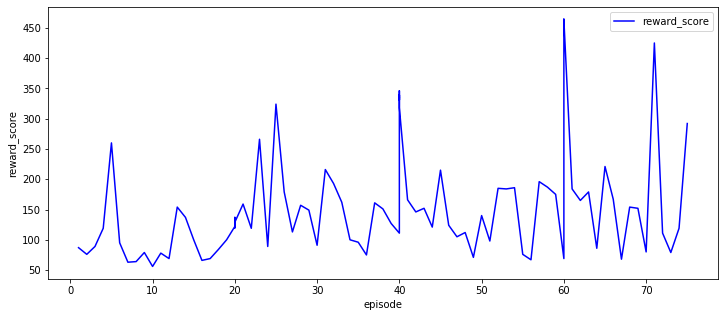

In [25]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [ ]:
# Cancelling robomaker job
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

# Stopping sagemaker training job
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

# Evaluation (Time trail, Object avoidance, Head to bot)

In [ ]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = s3_bucket
yaml_config['MODEL_S3_PREFIX']             = s3_prefix
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

### Clean Up Simulation Application Resource

In [ ]:
robomaker.delete_simulation_application(application=simulation_app_arn)

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
# Uncomment if you only want to clean the s3 bucket
sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
!aws s3 rm --recursive {sagemaker_s3_folder}

robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
!aws s3 rm --recursive {robomaker_s3_folder}

robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
!aws s3 rm --recursive {robomaker_sim_app}

model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
!aws s3 rm --recursive {model_output}

# Head-to-head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"
if not s3_prefix_2:
    raise Exception("Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between")

print("Using s3 bucket {}".format(s3_bucket_2))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket_2, s3_prefix_2))

In [ ]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MODEL_S3_PREFIX']             = [s3_prefix,
                                              s3_prefix_2]
yaml_config['MODEL_METADATA_FILE_S3_KEY']  =["{}/model/model_metadata.json".format(s3_prefix),
                                             "{}/model/model_metadata.json".format(s3_prefix_2)]
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = [s3_bucket,
                                              s3_bucket_2]
yaml_config['METRICS_S3_OBJECT_KEY']       = ["{}/evaluation_metrics.json".format(s3_prefix),
                                              "{}/evaluation_metrics.json".format(s3_prefix_2)]
yaml_config['SIMTRACE_S3_BUCKET']          = [s3_bucket,
                                              s3_bucket_2]
yaml_config['SIMTRACE_S3_PREFIX']          = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MP4_S3_OBJECT_PREFIX']        = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_1 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_1['elapsed_time'] = df_1['elapsed_time_in_milliseconds']/1000
df_1 = df_1[['trial', 'completion_percentage', 'elapsed_time']]

display(df_1)

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_2 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_2['elapsed_time'] = df_2['elapsed_time_in_milliseconds']/1000
df_2 = df_2[['trial', 'completion_percentage', 'elapsed_time']]

display(df_2)